A Deep Learning Toy Model for Image Compression
===

In this project, we will use simple deep learning networks for basic image compression.

You will get familiar with:

* train/test a simple deep learning model (for image compression in this project) with PyTorch library
* hyper-parameter tuning for deep learning model
* collect and analyse the training loss and metrics
* evaluate and visualize the result

## 1. Objectives
1. Train a baseline neural network.
2. Plot the loss-epoch curve.
3. Tune learning rate, the depth of the network, and different layers. Then compare the results in SSIM, PSNR.
4. Visualize some cases.
5. Customize your model (and loss, learning rate, scheduler, etc) for better performance.


## Get GPU ready

Change Runtime Type in the Colab menu to 'GPU'.

## Prepare the data

The data for training/test is at https://drive.google.com/drive/folders/1Ry2G14vY6uWoSG1rilvZOmNLvl3cOSUv?usp=sharing

1. Put this folder (and the data inside of course) in your GoogleDrive.
2. Run the command below to mount the GoogleDrive onto Colab.
3. Check the path to the data (e.g. `'/content/drive/MyDrive/MYDATA'`), and we will use this later.

Hint: you can check the file with either bash command or use the leftmost sidebar in Colab, there's a folder shaped icon.

**Note**: If you store the dataset in Google Drive, accessing the data might be slow due to Google Drive's limitations. Alternatively, you can upload the dataset to Colab's local runtime environment by clicking the '**Files**' button on the left sidebar. This approach can enhance data access speed during the session. However, please be aware that any data uploaded locally will be removed once you restart or exit the Colab session. To avoid data loss, consider reloading the data at the beginning of each session, or consistently use Google Drive mounting to manage your data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Check the data: When you do `!ls YOUR_DATA_PATH`, you should see `train` and `valid` under the dir.

In [ ]:
cd drive/MyDrive/ELEC5306/

/content/drive/MyDrive/ELEC5306-2022


## 1.1 Code Template
But feel free to modify if you think it's needed.

Let's first import packages for this project. You are not required to make modifications to this. But if you are using any other packages that's not included, feel free to import anytime.

In [ ]:
# ################################################
# import packages

import argparse
import math
import random
import shutil
import sys

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms


from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset


Then we define a Dataset class that could iterate over images under a directory (`root/split`).

You are not required to make modifications to this.

In [ ]:
# ################################################
# define our Dataset class

class ImageFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
                - img000.png
                - img001.png
                ...
            - valid/
                - img000.png
                - img001.png
                ...

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
        split (string): split mode ('train' or 'val')
    """

    def __init__(self, root, transform=None, split="train"):
        splitdir = Path(root) / split

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = [f for f in splitdir.iterdir() if f.is_file()]

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)


Then let's define a baseline neural network.

In [ ]:
# ###################################################
# a baseline model

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)

        return {
            "x_hat": x_hat,
        }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1)
        return {"x_hat": x_hat}


Let's check if this network structure works fine with data flow.

In [ ]:
# 1. get some random data
data = torch.zeros((1, 3, 128, 128))
# 2. get a random instance of the model class
model = Network(5, 5)
# 3. forward the data to the model
preds = model(data)
# 4. do compress
compressed = model.compress(data)
# 5. decompress
data_hat = model.decompress(compressed)

If there's no error pops out in the last code cell, then our network is fine.

We can compute the compression ratio of this network

In [ ]:
print('compression ratio: compressed/original {}'.format(compressed.numel() / data.numel()))

compression ratio: compressed/original 0.006510416666666667


The compression ratio of this random network is suprising, but we don't expect any good performance as the model is too small.

Usually the larger the model, the better the performance given sufficient training data and iterations.

Let's move on to the loss, average meter, and optimizer.

A good thing about this task is we don't need extra label but the input image.

The loss is simply compared between the decoded image and the original one.

In [ ]:
class Loss(nn.Module):

    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        out = {}
        out["mse_loss"] = self.mse(output["x_hat"], target)
        out["loss"] = out["mse_loss"] * 255

        return out

In [ ]:
class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def configure_optimizers(net, learning_rate):

    optimizer = optim.Adam(
        net.parameters(),
        lr=learning_rate,
    )

    return optimizer

In [ ]:
def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss.pth.tar")

After we almost got everything we need, we define a `train_one_epoch` function for training the model for one epoch.

In [ ]:
def train_one_epoch(
    model, criterion, train_dataloader, optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        if i % 10 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\tLoss: {out_criterion["loss"].item():.3f} |'
                f'\tMSE loss: {out_criterion["mse_loss"].item():.3f}'
            )


Likewise we further define a `test_epoch` function for getting the error on a valid set.

This part of data is not used in the training process, and will only be used to check the performance and give us implications of the performance of the model on unseen data.

This function returns the average loss on the valid split data.

In [ ]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f}\n"
    )

    return loss.avg

Finally we define a main function, and complete the whole training/testing process.

At the start of this main function, we define some arguments that's useful for training.

Define some arguments useful for training/validation.

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
dataset = '/content/drive/MyDrive/ELEC5306'       # path to the root of the dataset Modify this if you change the path
checkpoint = ''                                   # load pretrained model
epochs = 10                                       # total training epochs
num_workers = 2                                   # multi-process for loading training data
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-4
batch_size = 16
test_batch_size = 16
N = 128
M = 192

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
test_dataset = ImageFolder(dataset, split="valid", transform=test_transforms)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(device == "cuda"),
)

net = Network(N, M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")
for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )


Text(0.5, 1.0, 'compressed-decoded')

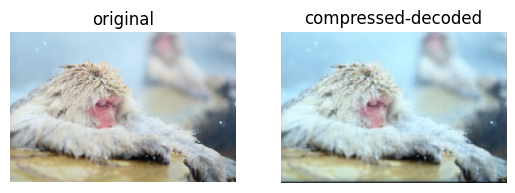

In [ ]:
# visualization
import matplotlib.pyplot as plt

dataset = '/content/drive/MyDrive/ELEC5306' # Modify this if you change the path
test_dataset = ImageFolder(dataset, split="valid", transform=transforms.ToTensor())
image = test_dataset[1].unsqueeze(0).to(device)
net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted = net(image)['x_hat'].squeeze(0).detach()

fig, axes = plt.subplots(1,2)
axes[0].imshow(image.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

## 1.2 PSNR as AverageMeter for testing


A scratch example of PSNR, no guarantee of working.

Free to grab online.




In [ ]:
def PSNR(img1, img2):
    # img1 and img2 within range [0, 1]
    img1, img2 = img1.detach(), img2.detach()
    img1 = img1 * 255
    img2 = img2 * 255
    batch_size = img1.shape[0]
    img1 = img1.reshape(batch_size, -1)
    img2 = img2.reshape(batch_size, -1)
    mse = torch.mean((img1 - img2) ** 2)
    return torch.mean(20 * torch.log10(255.0 / torch.sqrt(mse)))


A scratch example of SSIM, details are at https://github.com/VainF/pytorch-msssim

In [ ]:
!pip install pytorch-msssim

In [ ]:
import torch
from pytorch_msssim import ssim

# X: (N,3,H,W) a batch of non-negative RGB images (0~1)
# Y: (N,3,H,W)

X = torch.randn((2, 3, 10, 10))
Y = torch.randn((2, 3, 10, 10))

X = X * 255
Y = Y * 255

# calculate ssim & ms-ssim for each image
ssim_val = ssim(X, Y, data_range=255, size_average=False) # return (N,)
print(ssim_val)


Your code here:

In [ ]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()
    # psnr = AverageMeter()
    # ssim = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            # psnr.update(PSNR(d_out, d))
            # ssim.update(ssim(d * 255, d_out * 255), data_range=255, size_average=True)

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f}\n"
    )

    return loss.avg

# do the test on valid split

## 1.3 Loss-Epoch curve


A naive example, no guarantee of working.

In [ ]:
loss_epoch = list()

for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    #
    loss_epoch.append(loss)
    #
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

assert last_epoch == 0
xs = range(1, epochs+1)
ys = loss_epoch
# do plot



Your code here: